### Data wrangling

Import Libraries

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
from math import floor, ceil

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from rioxarray.merge import merge_arrays # Merge rasters

import matplotlib.pyplot as plt
# interactive plots of vector data
import hvplot.pandas

Load Data

In [11]:
# Init datasets
datasets_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'datasets'
)

# Create project data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'data'
)

# Define the directory name for USFS data
land_units_dir = os.path.join(data_dir, 'usfs-national-lands')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

In [13]:
# Only extract once
usfs_pattern = os.path.join(land_units_dir, '*.shp')

if not glob(usfs_pattern):
    usfs_zip = f'{datasets_dir}/S_USA.NFSLandUnit.zip'

    # Unzip data
    with zipfile.ZipFile(usfs_zip, 'r') as zip:
        zip.extractall(path=land_units_dir)

# Find the extracted .shp file path
usfs_land_path = glob(usfs_pattern)[0]

# Load USFS land units from shapefile
usfs_land_units_gdf = (
    gpd.read_file(usfs_land_path)
)

# Obtain units with location name
valid_units = usfs_land_units_gdf.dropna(subset=['HQ_LOCATIO'])

# Select only CA units
all_ca_units = valid_units[valid_units['HQ_LOCATIO'].str.contains('CA')]

Explore Sites

In [23]:
# Los Padres National Forest
los_padres_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Los Padres National Forest']

# plot with EsriImagery basemap  
los_padres_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Los Padres National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [18]:
# Eldorado National Forest
eldorado_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Eldorado National Forest']

# plot with EsriImagery basemap  
eldorado_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Eldorado National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [48]:
def create_polaris_urls(soil_prop, stat, soil_depth, gdf_bounds):
    """Create POLARIS dataset urls using site bounds"""

    # Get latitude and longitude bounds from site
    min_lon, min_lat, max_lon, max_lat = gdf_bounds

    site_min_lon = floor(min_lon) 
    site_min_lat = floor(min_lat)  
    site_max_lon = ceil(max_lon)  
    site_max_lat = ceil(max_lat)

    all_soil_urls = []

    for lon in range(site_min_lon, site_max_lon):
        for lat in range(site_min_lat, site_max_lat):
            current_max_lon = lon + 1
            current_max_lat = lat + 1

            soil_template = (
                "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
                "{soil_prop}/"
                "{stat}/"
                "{soil_depth}/"
                "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

            soil_url = soil_template.format(
                soil_prop=soil_prop, stat=stat, soil_depth=soil_depth,
                min_lat=lat, max_lat=current_max_lat, 
                min_lon=lon, max_lon=current_max_lon
            )

            all_soil_urls.append(soil_url)

    return all_soil_urls

In [49]:
def build_da(urls):
    """Build a DataArray from a set of urls"""

    all_das = []

    for url in urls:
        # open file
        da = rxr.open_rasterio(
                url,
                mask_and_scale=True # for the fill value
            ).squeeze()
        all_das.append(da)

    merged = merge_arrays(all_das)
    return merged

In [55]:
# Set site parameters
soil_prop = 'ph'
soil_prop_stat = 'mean'
soil_depth = '30_60' # cm (the minimum depth for blue oaks is 1-2 ft)

# Build soil DataArrays 

# Eldorado site
ed_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, eldorado_gdf.total_bounds)
eldorado_da = build_da(ed_polaris_urls)

# Los Padres site
lp_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, los_padres_gdf.total_bounds)
los_padres_da = build_da(lp_polaris_urls)

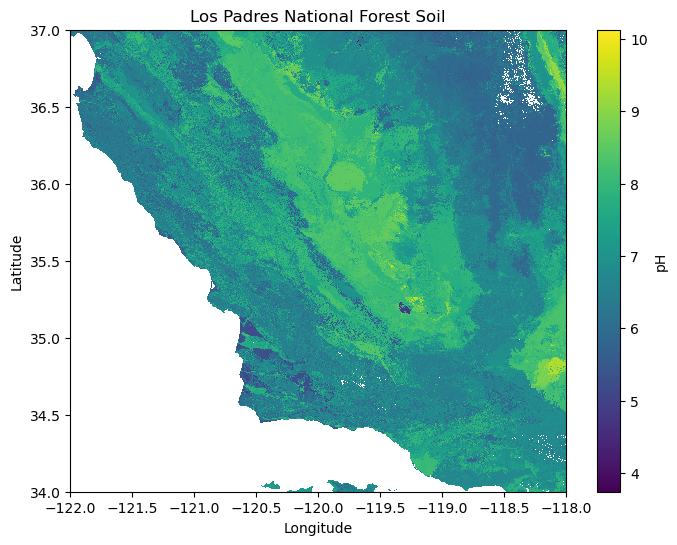

In [53]:
# Plot Los Padres soils

fig = plt.figure(figsize=(8, 6)) 
ax = plt.axes()

# mean pH values 
los_padres_soil_plt = los_padres_da.plot(cbar_kwargs={'label': 'pH'})

plt.title('Los Padres National Forest Soil')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

fig.savefig("images/Los-Padres-National-Forest-Soil.png") 

los_padres_soil_plt

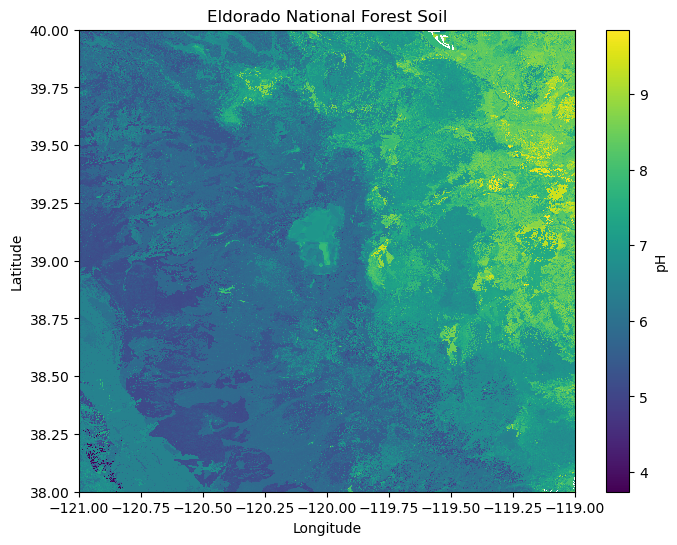

In [56]:
# Plot Eldorado soils

fig = plt.figure(figsize=(8, 6)) 
ax = plt.axes()

# mean pH values
eldorado_soil_plt = eldorado_da.plot(cbar_kwargs={'label': 'pH'})

plt.title('Eldorado National Forest Soil')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

fig.savefig("images/Eldorado-National-Forest-Soil.png") 

eldorado_soil_plt